<div >
<img src = "../banner.jpg" />
</div>

<a target="_blank" href="https://colab.research.google.com/github/ignaciomsarmiento/BDML_SS/blob/main/Lecture09/Notebook_SS09_Arboles
.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# CARTs, Bagging and Random Forests

## Predicting House Prices

Our objective today is to construct a model to predict house prices. From Rosen's landmark paper "Hedonic Prices and Implicit Markets: Product Differentiation in Pure Competition" (1974), we know that a vector of its characteristics describes a differentiated good.

In the case of a house, these characteristics may include structural attributes (e.g., number of bedrooms), neighborhood public services (e.g., local school quality), and local amenities (e.g., crime, air quality, etc). Thus, we can write the market price of the house as:

$$
Price=f(structural\,attributes,amenities,...)
$$


However, Rosen's theory doesn't tell us much about the functional form of $f$. 

## CARTS

Let's load the packages:

In [1]:
# install.packages("pacman") #run this line if you use Google Colab

In [2]:
#packages
require("pacman")
p_load("tidyverse","ggplot2")

Loading required package: pacman



 And the toy data set:

In [3]:
db<-read.csv('https://raw.githubusercontent.com/ignaciomsarmiento/datasets/main/toy_houses.csv')

In [4]:
head(db)

,price,habitaciones,DCBD
,<dbl>,<int>,<dbl>
1,162753.09,3,1.190307
2,73131.30,0,1.910839
3,162757.45,2,1.227716
4,73127.75,1,1.824990
5,73128.71,0,1.915576
6,98715.60,3,1.505208


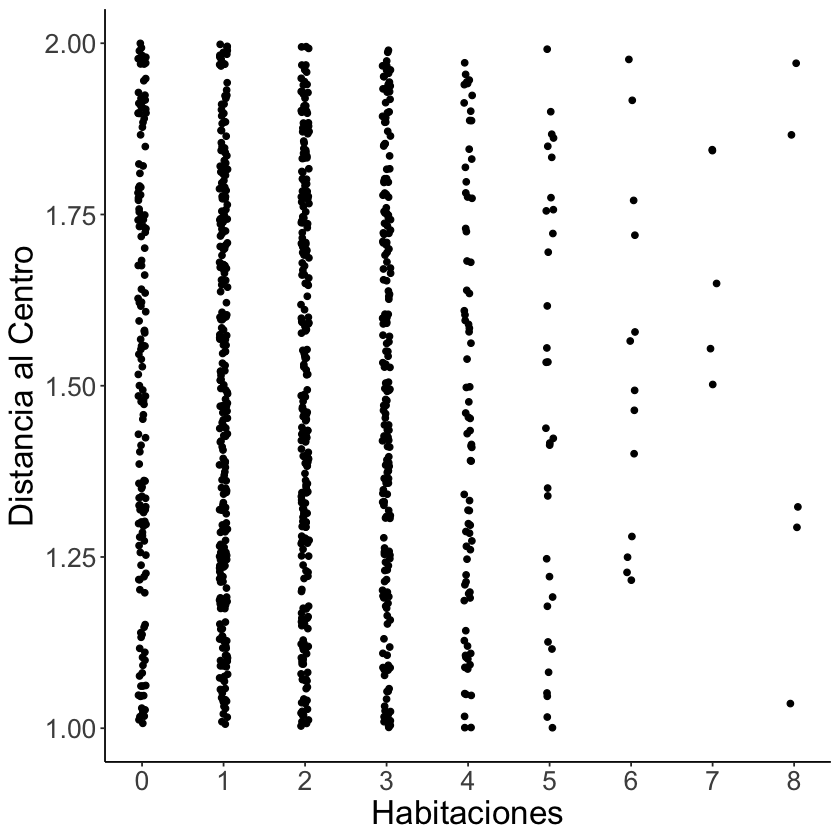

In [5]:
ggplot(db) +
  geom_point(aes(x=habitaciones,y=DCBD),position=position_jitter(width = .05)) +
  scale_x_continuous(breaks=seq(0,8,1)) +
  theme_classic() +
  xlab("Habitaciones") +
  ylab("Distancia al Centro") +
  theme(legend.position =  "none",
      text=element_text(size=20))

### Algorithm


-  Datos: $y_{n\times 1}$  y $X_{n\times k}$ 

-  Definiciones


    -  $j$ es la variable que parte el espacio y  $s$ es el punto de partición

    -  Defina los siguientes semiplanos

\begin{align}
R_1(j,s)=\{X|X_j\leq s\} \,\,\, \& \,\,\, R_2(j,s)=\{X|X_j > s\}
\end{align}

-  *El problema*: buscar la variable de partición $X_j$ y el punto $s$ de forma tal que 


\begin{align}
\underset{j,s}{min} \left[ \underset{y_{R_1}}{min}\sum_{x_i\in R_1(j,s)}(y-y_{R_1})^2+ \underset{y_{R_2}}{min}\sum_{x_i\in R_2(j,s)}(y-y_{R_2})^2\right]
\end{align}



#### Algorithm by hand ("artesanal")

1. Iniciemos por DBCD

In [6]:
MSE_dbcd<-NA

j<-1
for(i in seq(1,2,0.25)){
    #Region 1
  R1<- db %>% filter(DCBD<=i)
  R1<- R1 %>% mutate(c1=mean(price))
  MSEr1<- ifelse(is.na(mean((R1$price-R1$c1)^2)),0,mean((R1$price-R1$c1)^2))
    #Region 2
  R2<- db %>% filter(DCBD>i)
  R2<- R2 %>% mutate(c2=mean(price))
  MSEr2<- ifelse(is.na(mean((R2$price-R2$c2)^2)),0,mean((R2$price-R2$c2)^2))
  
  MSE_dbcd[j]<-MSEr1+MSEr2
  j<-j+1
}

MSE_dbcd

[1] 1716336929 1619184821  144556602 1612314034 1716336929

2. Luego por Habitaciones

In [7]:
MSE_hab<-NA

for(i in 0:8){
  R1<- db %>% filter(habitaciones<=i)
  R1<- R1 %>% mutate(c1=mean(price))
  MSEr1<- ifelse(is.na(mean((R1$price-R1$c1)^2)),0,mean((R1$price-R1$c1)^2))
  R2<- db %>% filter(habitaciones>i)
  R2<- R2 %>% mutate(c2=mean(price))
  MSEr2<- ifelse(is.na(mean((R2$price-R2$c2)^2)),0,mean((R2$price-R2$c2)^2))
  
  MSE_hab[i+1]<-MSEr1+MSEr2
  
}
MSE_hab

[1] 3655836376 3478068100 3029642859 2817877745 2778785039 2740560656 2585869900
[8] 2703378640 1716336929

Mínimo?


In [8]:
MSE<-c(MSE_dbcd,MSE_hab)
MSE[which.min(MSE)]
MSE

[1] 144556602

[1] 1716336929 1619184821  144556602 1612314034 1716336929 3655836376
 [7] 3478068100 3029642859 2817877745 2778785039 2740560656 2585869900
[13] 2703378640 1716336929

<iframe src="m.html"></iframe>

#### Algorithm in R

There are multiple packages, we are going to use `rpart`

In [9]:
p_load("rpart")

In [10]:
mytree<-rpart(log(price)~DCBD+habitaciones,data=db)

In [11]:
mytree

n= 1000 

node), split, n, deviance, yval
      * denotes terminal node

1) root 1000 1.323913e+02 11.66130  
  2) DCBD>=1.499274 483 9.599378e+00 11.29876  
    4) habitaciones< 2.5 324 5.722203e-07 11.20000 *
    5) habitaciones>=2.5 159 1.741396e-07 11.50000 *
  3) DCBD< 1.499274 517 1.785914e-07 12.00000 *

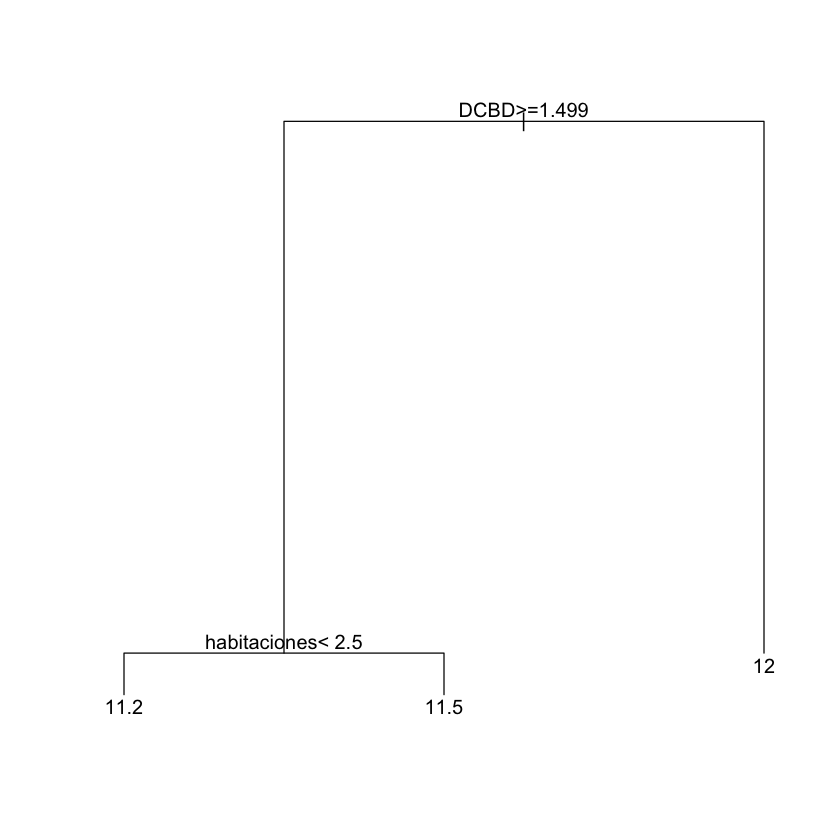

In [12]:
plot(mytree)
text(mytree)

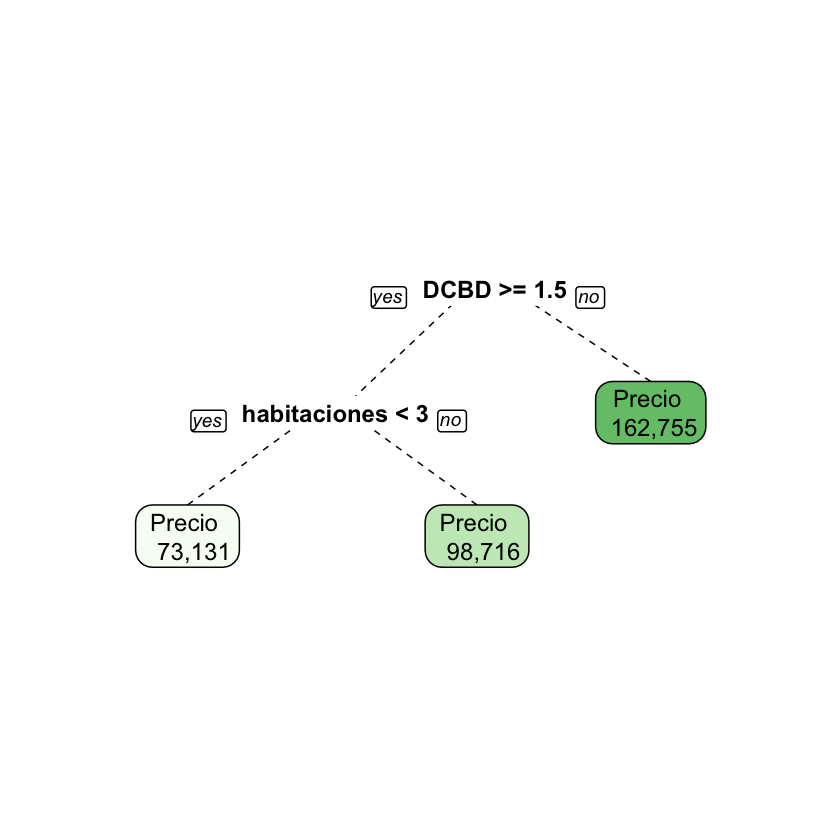

In [13]:
p_load("rpart.plot")

prp(mytree, under = TRUE, branch.lty = 2, yesno = 2, faclen = 0, varlen=15,tweak=1.2,clip.facs= TRUE,box.palette = "Greens",compress=TRUE,ycompress = TRUE,node.fun=function(x, labs, digits, varlen) paste("Precio \n", format(round(exp(mytree$frame$yval), 0), nsmall=0, big.mark=",")))

In [14]:
mytree_full<-rpart(log(price)~DCBD+habitaciones,data=db,cp=-1)

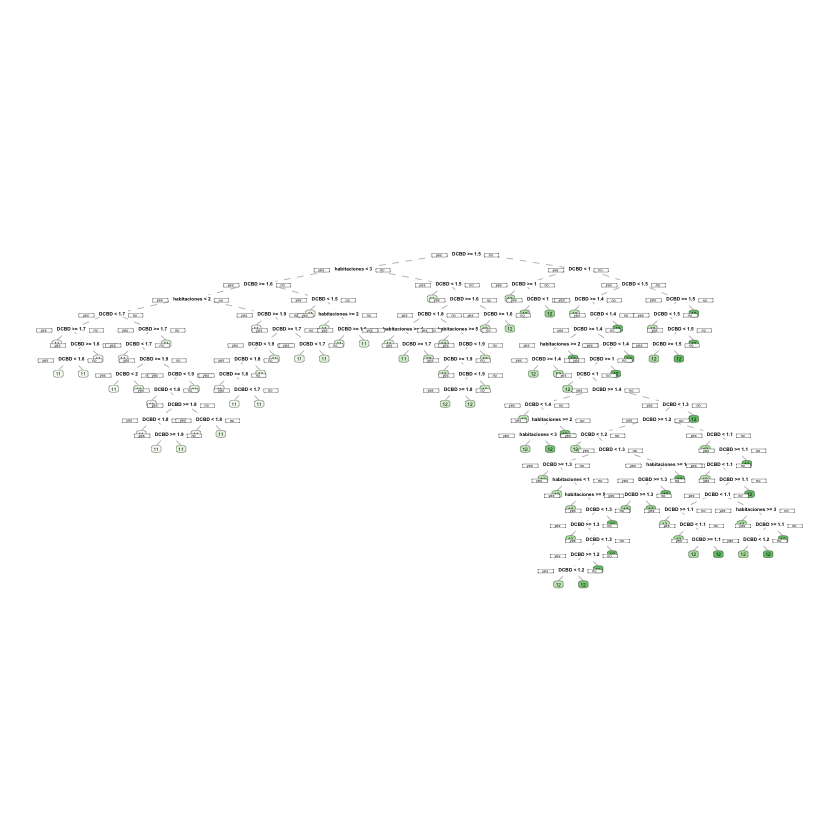

In [15]:
prp(mytree_full, under = TRUE, branch.lty = 2, yesno = 2, faclen = 0, varlen=15,tweak=1.2,clip.facs= TRUE,box.palette = "Greens",compress=TRUE,ycompress = TRUE)

##### With Ames Data Set

In [16]:
p_load("modeldata")

data("ames", package = "modeldata")

ames<-ames  %>% filter(Neighborhood %in%c("North_Ames", "College_Creek", "Old_Town", "Edwards", "Somerset", "Northridge_Heights", "Gilbert", "Sawyer", "Northwest_Ames", "Sawyer_West"))


In [17]:
head(ames)

MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,⋯,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
<fct>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<int>,<dbl>,<dbl>
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,⋯,No_Fence,None,0,5,2010,WD,Normal,215000,-93.61975,42.05403
One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,⋯,Minimum_Privacy,None,0,6,2010,WD,Normal,105000,-93.61976,42.05301
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,⋯,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,-93.61939,42.05266
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,⋯,No_Fence,None,0,4,2010,WD,Normal,244000,-93.61732,42.05125
Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,⋯,Minimum_Privacy,None,0,3,2010,WD,Normal,189900,-93.63893,42.06090
Two_Story_1946_and_Newer,Residential_Low_Density,78,9978,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,⋯,No_Fence,None,0,6,2010,WD,Normal,195500,-93.63893,42.06078


The description of the variables can be viewed here: https://jse.amstat.org/v19n3/decock/DataDocumentation.txt

In [18]:
class(ames$Fence)

[1] "factor"

In [19]:
amestree<-rpart(log(Sale_Price) ~ Gr_Liv_Area  + Bldg_Type + Fence,data=ames,cp=0.02)

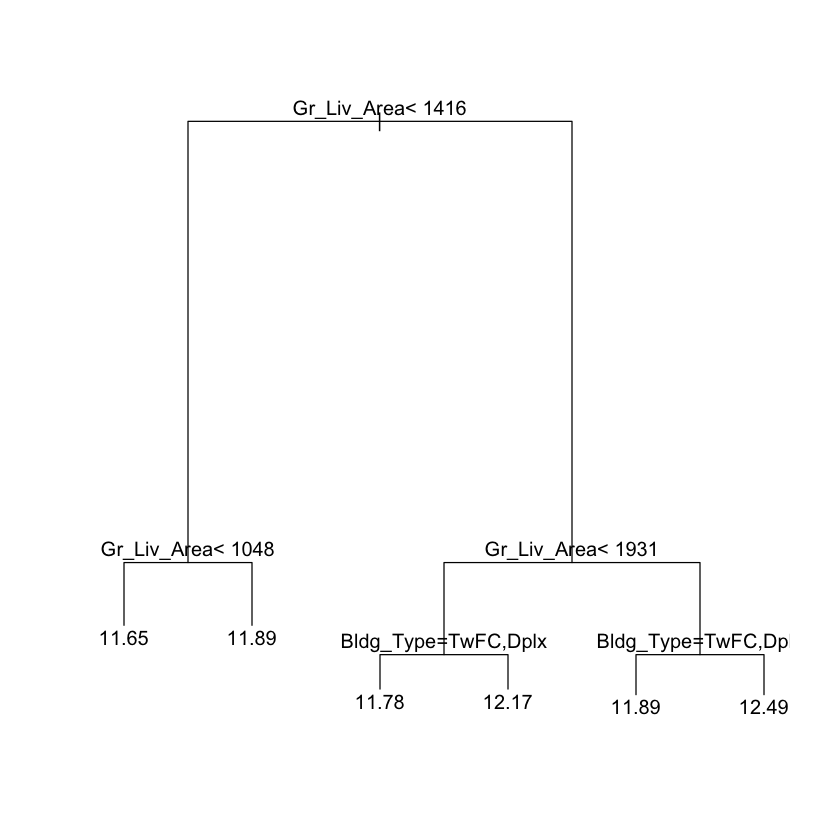

In [20]:
plot(amestree)
text(amestree,pretty=TRUE)

## With tidymodels

In [21]:
p_load("tidymodels")

tree_model <- decision_tree(min_n = 2) %>% 
  set_engine("rpart") %>% 
  set_mode("regression")

In [22]:
tree_fit <- 
  tree_model %>% 
  fit(log(Sale_Price) ~ Gr_Liv_Area  + Bldg_Type  + Fence ,data=ames)

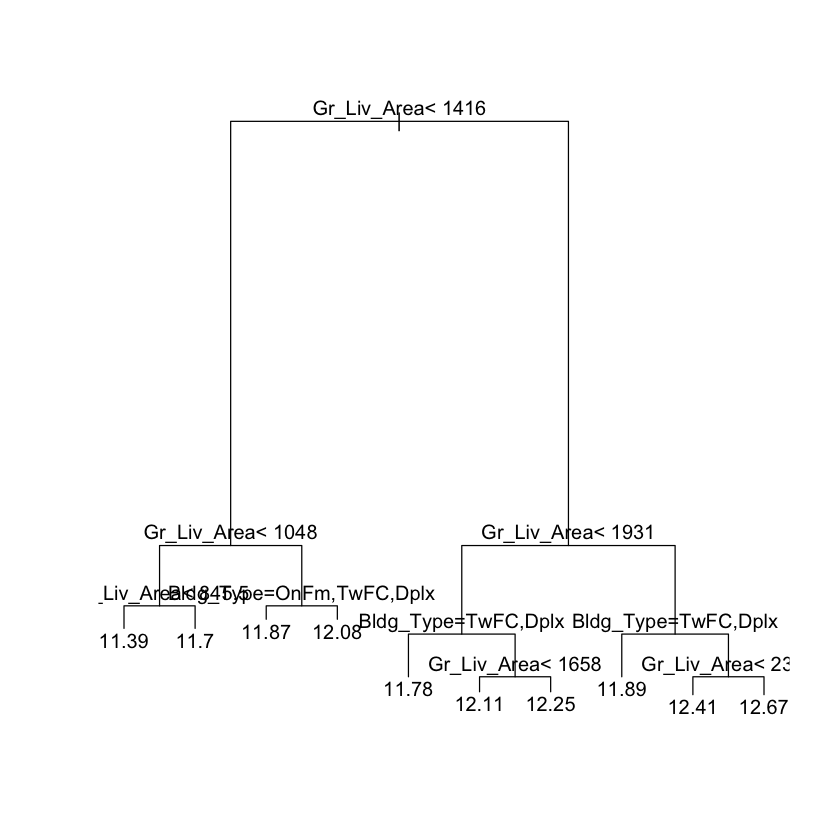

In [23]:
plot(tree_fit$fit)
text(tree_fit$fit,pretty=TRUE)

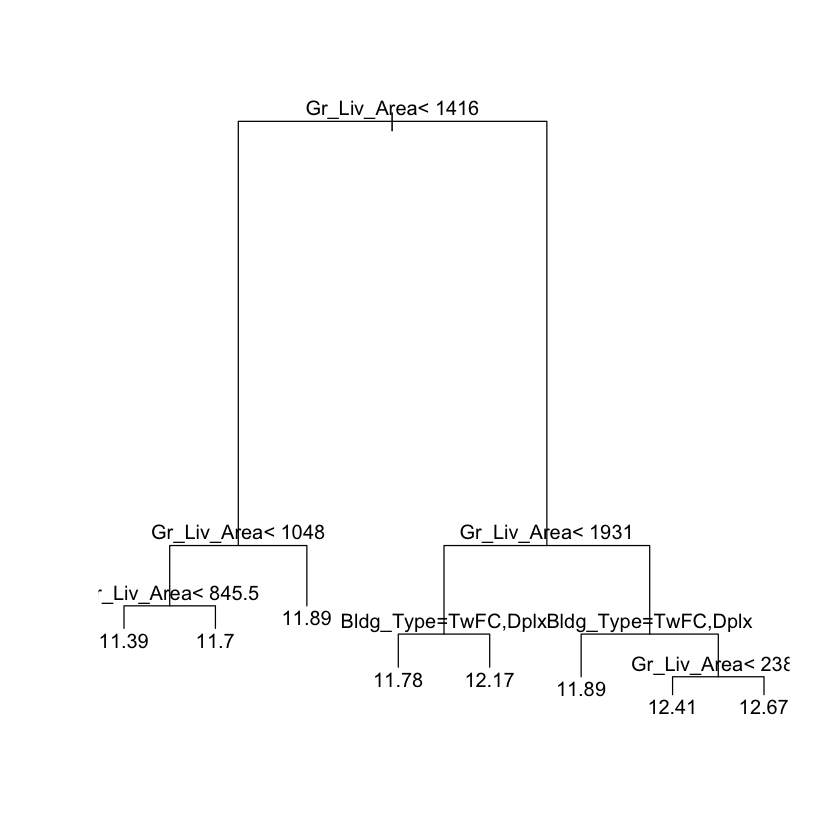

In [24]:
tree_model2 <- decision_tree(cost_complexity = .012) %>% 
  set_engine("rpart") %>% 
  set_mode("regression") %>% 
  fit(log(Sale_Price) ~ Gr_Liv_Area  + Bldg_Type  + Fence ,data=ames)

plot(tree_model2$fit)
text(tree_model2$fit,pretty=TRUE)


### Cost Complexity Prunning

In [25]:
# Model setting
tree_model_tune <- decision_tree(cost_complexity = tune()) %>% 
  set_engine("rpart") %>% 
  set_mode("regression") 


In [28]:
# Receipe
rec_1 <- recipe(Sale_Price ~  Gr_Liv_Area  + Bldg_Type  + Fence ,data=ames)  %>% 
         step_log(Sale_Price)

In [30]:
set.seed(234)
ames_folds <- vfold_cv(ames,
              v       = 5
             )

In [34]:
tree_wf <- workflow() %>%
                     add_recipe(rec_1) %>%
                     add_model(tree_model_tune)

In [35]:
tree_grid <- grid_regular(cost_complexity(),
                          levels = 5) #at least 100

In [36]:
#train
tree_res <- 
  tree_wf %>% 
  tune_grid(
    resamples = ames_folds,
    grid = tree_grid,
    metrics= metric_set( mae)      
    )


In [39]:
tree_res %>% 
  collect_metrics(summarize = TRUE)

cost_complexity,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1.000000e-10,mae,standard,0.1953027,5,0.002970243,Preprocessor1_Model1
1.778279e-08,mae,standard,0.1953027,5,0.002970243,Preprocessor1_Model2
3.162278e-06,mae,standard,0.1952932,5,0.002974235,Preprocessor1_Model3
5.623413e-04,mae,standard,0.1910897,5,0.003209810,Preprocessor1_Model4
1.000000e-01,mae,standard,0.2308395,5,0.004611652,Preprocessor1_Model5


In [ ]:
?collect_metrics

In [43]:
best_tree <- tree_res %>%
  select_best("mae")

In [44]:
final_wf <- 
  tree_wf %>% 
  finalize_workflow(best_tree)

final_wf

══ Workflow ══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: decision_tree()

── Preprocessor ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
1 Recipe Step

• step_log()

── Model ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Decision Tree Model Specification (regression)

Main Arguments:
  cost_complexity = 0.000562341325190349

Computational engine: rpart 


#### Tunning Hiper-parameters

#####  `method=rpart`  only allows to tune Complexity Parameter

- Can change the length


In [ ]:
# Model setting
tree_model_tune_params <- decision_tree(tree_depth = tune(),
                                        min_n      = tune()) %>% 
  set_engine("rpart") %>% 
  set_mode("regression") 


In [47]:
?rpart.control

In [ ]:
tree_wf <- workflow() %>%
                     add_recipe(rec_1) %>%
                     add_model(tree_model_tune_params)

tree_grid <- grid_regular( # Rango de búsqueda para cada hiperparámetro
                  tree_depth(range = c(1, 10), trans = NULL),
                  min_n(range = c(2, 100), trans = NULL),
                  # Número valores por hiperparámetro
                  levels = c(3, 3))  

In [ ]:
tree_grid_Random <- grid_random( # Rango de búsqueda para cada hiperparámetro
                  tree_depth(range = c(1, 10), trans = NULL),
                  min_n(range = c(2, 100), trans = NULL),
                  # Número valores por hiperparámetro
                  levels = c(3, 3)) 

<div >
<img src = "figures/gridsearch.png" />
</div>

In [ ]:

tree_res_Random <- 
  tree_wf %>% 
  tune_grid(
    resamples = ames_folds,
    grid = tree_grid_Random,
    metrics= metric_set( mae)      
    )


In [ ]:
best_tree <- tree_res %>%
  select_best("mae")